# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**.

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [ ]:
data = pd.read_csv('/content/cost_revenue_dirty.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [ ]:
data.shape

(5391, 6)

In [ ]:
data.isna().values.any()

False

In [ ]:
data.duplicated().any()

False

In [ ]:
data.dtypes

,0
Rank,int64
Release_Date,object
Movie_Title,object
USD_Production_Budget,object
USD_Worldwide_Gross,object
USD_Domestic_Gross,object


### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`.
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [ ]:
data.USD_Production_Budget = pd.to_numeric(data.USD_Production_Budget.astype(str).str.replace('[\$,]', '', regex=True))
data.USD_Worldwide_Gross = pd.to_numeric(data.USD_Worldwide_Gross.astype(str).str.replace('[\$,]', '', regex=True))
data.USD_Domestic_Gross = pd.to_numeric(data.USD_Domestic_Gross.astype(str).str.replace('[\$,]', '', regex=True))

**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type.

In [ ]:
data.Release_Date = pd.to_datetime(data.Release_Date)
data.dtypes

,0
Rank,int64
Release_Date,datetime64[ns]
Movie_Title,object
USD_Production_Budget,int64
USD_Worldwide_Gross,int64
USD_Domestic_Gross,int64


### Descriptive Statistics

**Challenge**:

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [ ]:
data.describe()

,Rank,Release_Date,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
count,"5,391.00",5391,"5,391.00","5,391.00","5,391.00"
mean,"2,696.00",2003-09-19 15:02:02.203672704,"31,113,737.58","88,855,421.96","41,235,519.44"
min,1.00,1915-08-02 00:00:00,"1,100.00",0.00,0.00
25%,"1,348.50",1999-12-02 12:00:00,"5,000,000.00","3,865,206.00","1,330,901.50"
50%,"2,696.00",2006-06-23 00:00:00,"17,000,000.00","27,450,453.00","17,192,205.00"
75%,"4,043.50",2011-11-23 00:00:00,"40,000,000.00","96,454,455.00","52,343,687.00"
max,"5,391.00",2020-12-31 00:00:00,"425,000,000.00","2,783,918,982.00","936,662,225.00"
std,"1,556.39",NaN,"40,523,796.88","168,457,757.00","66,029,346.27"


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [ ]:
# data[data.USD_Domestic_Gross == 0].count()
data[data.USD_Domestic_Gross == 0].sort_values('USD_Production_Budget', ascending=False).head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [ ]:
data[data.USD_Worldwide_Gross == 0].count()
data[data.USD_Worldwide_Gross == 0].sort_values('USD_Production_Budget', ascending=False).head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross


### Filtering on Multiple Conditions

In [ ]:
international_releases = data.loc[
    (data.USD_Domestic_Gross == 0) &
    (data.USD_Worldwide_Gross != 0)
]
international_releases.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross


**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States.

Hint: This time you'll have to use the `and` keyword.

In [ ]:
international_releases = data.query('(USD_Domestic_Gross == 0) and (USD_Worldwide_Gross != 0)')
international_releases.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office?
* Create another DataFrame called data_clean that does not include these films.

In [ ]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [ ]:
unreleased_films = data.loc[data.Release_Date > scrape_date]
len(unreleased_films)
unreleased_films.head()
data_clean = data.loc[data.Release_Date <= scrape_date]
data_clean.count()

,0
Rank,5384
Release_Date,5384
Movie_Title,5384
USD_Production_Budget,5384
USD_Worldwide_Gross,5384
USD_Domestic_Gross,5384


### Films that Lost Money

**Challenge**:
What is the percentage of films where the production costs exceeded the worldwide gross revenue?

In [ ]:
films = data.loc[data.USD_Production_Budget > data.USD_Worldwide_Gross]
len(films)/len(data) * 100

37.3585605639028

# Seaborn for Data Viz: Bubble Charts

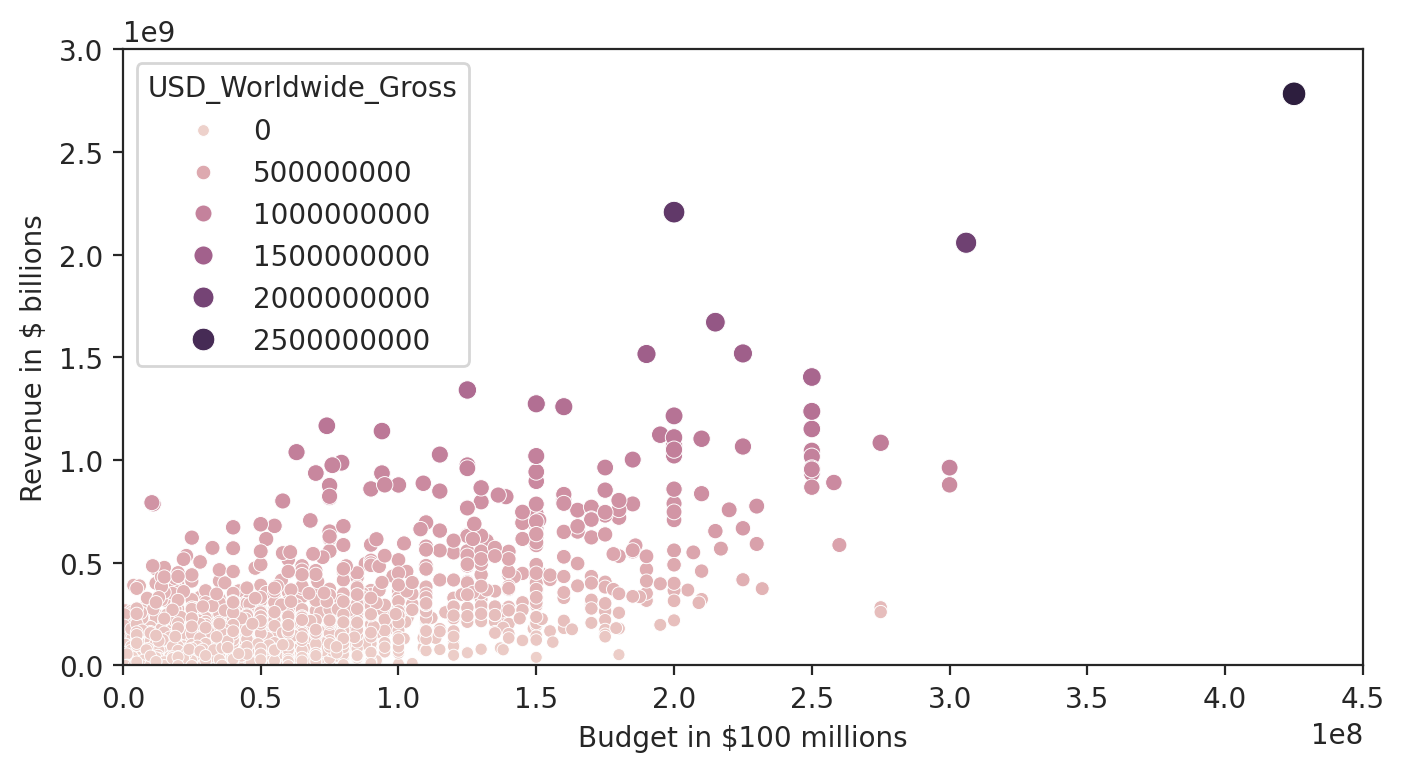

In [ ]:
plt.figure(figsize=(8, 4), dpi=200)

with sns.axes_style('ticks'):
  ax = sns.scatterplot(
      data=data_clean,
      x = 'USD_Production_Budget',
      y = 'USD_Worldwide_Gross',
      hue='USD_Worldwide_Gross',
      size='USD_Worldwide_Gross'
  )
  ax.set(
      ylim=(0, 3000000000),
      xlim=(0, 450000000),
      ylabel='Revenue in $ billions',
      xlabel='Budget in $100 millions'
  )
plt.show()

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



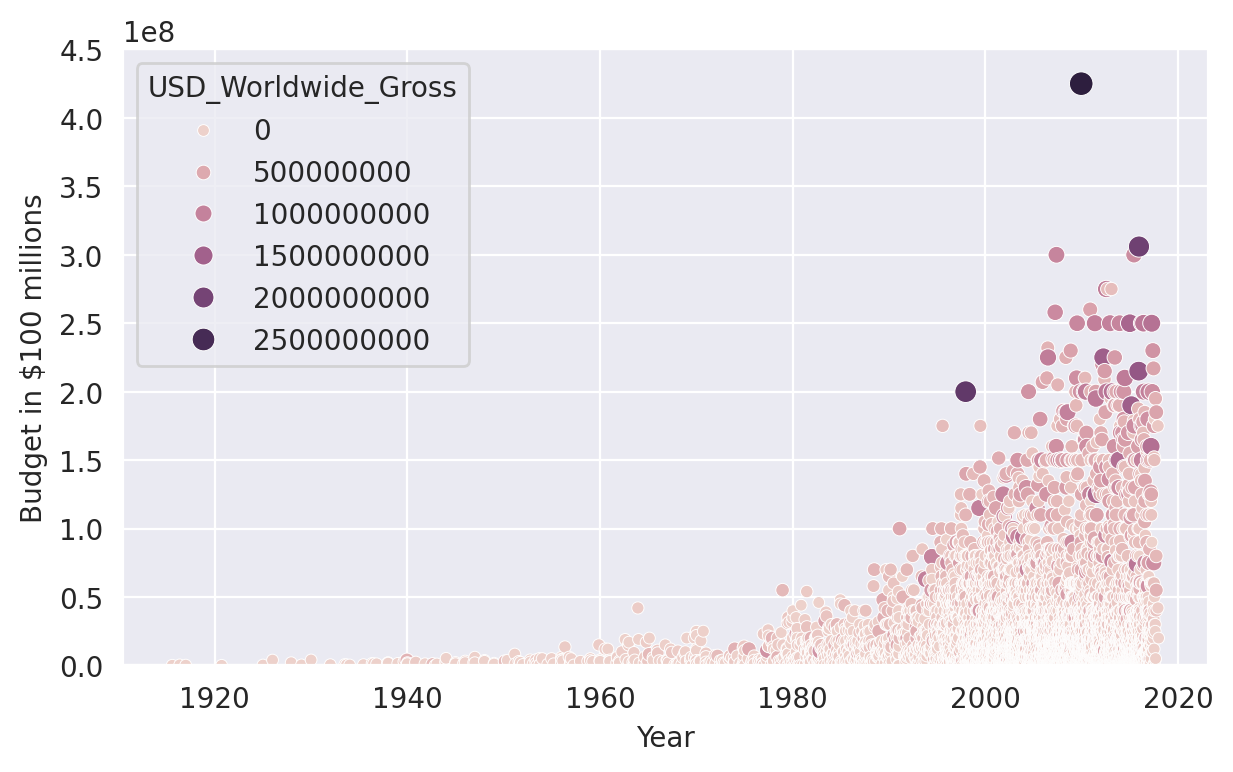

In [ ]:
plt.figure(figsize=(7, 4), dpi=200)

with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(
      data=data_clean,
      x='Release_Date',
      y='USD_Production_Budget',
      hue='USD_Worldwide_Gross',
      size='USD_Worldwide_Gross'
  )
  ax.set(
      ylim=(0, 450000000),
      ylabel='Budget in $100 millions',
      xlabel='Year'
  )

plt.show()

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release.

<img src=https://i.imgur.com/0VEfagw.png width=650>

Here's how:
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column.
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [ ]:
dates = pd.DatetimeIndex(data_clean.Release_Date).year
data_clean['Decade'] = dates // 10 * 10
data_clean.head()

<ipython-input-23-10dad8aa24eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Decade'] = dates // 10 * 10


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,1910
1,5140,1916-05-09,Intolerance,385907,0,0,1910
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,1910
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,1920
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000,1920


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [ ]:
old_films = data_clean.loc[data_clean.Decade <= 1960]
new_films = data_clean.loc[data_clean.Decade > 1960]
len(old_films)
old_films.loc[old_films.USD_Production_Budget.idxmax()]

,109
Rank,1253
Release_Date,1963-12-06 00:00:00
Movie_Title,Cleopatra
USD_Production_Budget,42000000
USD_Worldwide_Gross,71000000
USD_Domestic_Gross,57000000
Decade,1960


# Seaborn Regression Plots

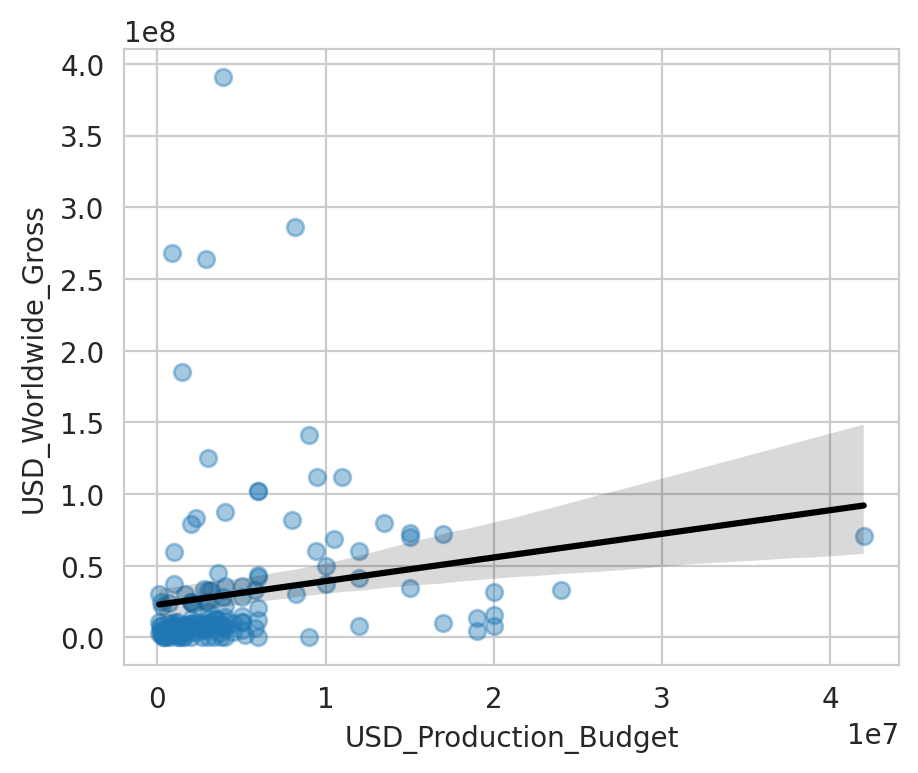

In [ ]:
plt.figure(figsize=(5, 4), dpi=200)
with sns.axes_style('whitegrid'):
  sns.regplot(
    data=old_films,
    x='USD_Production_Budget',
    y='USD_Worldwide_Gross',
    scatter_kws={'alpha': 0.4},
    line_kws={'color': 'black'}
)


**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`.
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

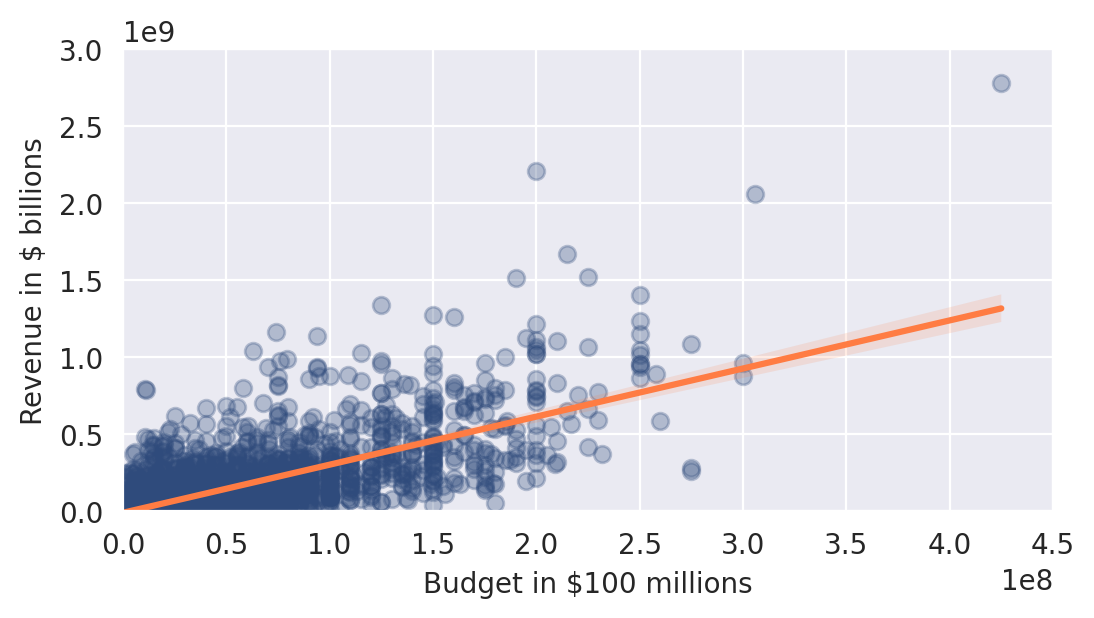

In [ ]:
plt.figure(figsize=(6, 3), dpi=200)
with sns.axes_style('darkgrid'):
  ax = sns.regplot(
      data=new_films,
      x='USD_Production_Budget',
      y='USD_Worldwide_Gross',
      color='#2f4b7c',
      scatter_kws={'alpha': 0.3},
      line_kws={'color': '#ff7c43'}
  )
  ax.set(
      ylim=(0, 3000000000),
      xlim=(0, 450000000),
      ylabel='Revenue in $ billions',
      xlabel='Budget in $100 millions'
  )

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [ ]:
regression = LinearRegression()

**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [ ]:
X = pd.DataFrame(new_films, columns=['USD_Production_Budget'])
y = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross'])
regression.fit(X, y)

LinearRegression()

In [ ]:
regression.intercept_
regression.coef_
regression.score(X, y)

0.5577032617720403

In [ ]:
X = pd.DataFrame(old_films, columns=['USD_Production_Budget'])
y = pd.DataFrame(old_films, columns=['USD_Worldwide_Gross'])

regression.fit(X, y)
print(f'Intercept: {regression.intercept_}')
print(f'Coefficient: {regression.coef_}')
regression.score(X, y)

Intercept: [22821538.63508039]
Coefficient: [[1.64771314]]


0.02937258620576877

# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million?

In [ ]:
budget = 350000000
theta_zero = regression.intercept_[0]
theta_one = regression.coef_[0, 0]
revenue = theta_zero + theta_one * budget
revenue_estimate = round(revenue, -6)
revenue_estimate

600000000.0

In [ ]:
22821538 + 1.64771314 * 350000000

599521137.0

In [ ]:
print(f'The estimated revenue for a $350 film is around ${revenue_estimate:.10}.')

The estimated revenue for a $350 film is around $600000000.0.
